In [1]:
%matplotlib inline

from datetime import datetime
tic = datetime.now()

import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

# THIS_DIR = getcwd()
# CLASS_DIR = abspath(join(THIS_DIR, 'dsnclasses'))  #abspath(join(THIS_DIR, '../../..', 'dsnclasses'))
# sys.path.append(CLASS_DIR)

In [2]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
location = 'tokyo'
year = 2010

THIS_DIR = getcwd()
SDATA_DIR = abspath(join(THIS_DIR, '../' 'solar_data'))  #abspath(join(THIS_DIR, '../../..', 'data'))

sfile = SDATA_DIR + '/' + location +'/' + str(year) + '.csv'

#skiprows=4 to remove unnecessary title texts
#usecols=4 to read only the Global Solar Radiation (GSR) values
solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])

#convert dataframe to numpy array
solar_radiation = solar_radiation.values

#convert missing data in CSV files to zero
solar_radiation[np.isnan(solar_radiation)] = 0

#reshape solar_radiation into no_of_daysx24 array
solar_radiation = solar_radiation.reshape(-1,24)

#GSR values (in MJ/sq.mts per hour) need to be expressed in mW
# Conversion is accomplished by 
# solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)
# the factor of 2 in the end is assuming two solar cells
senergy = 2*solar_radiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60)


In [4]:
# no_of_days_to_plot = len(solar_radiation)
# plt.figure
# for i in range(no_of_days_to_plot):
#     plt.plot(senergy[i])
# plt.show()

In [5]:
HMAX = 1000 #Maximum harvested energy
senergy = np.clip(senergy,0,HMAX)
DAY = 200
henergy = senergy[DAY]

In [6]:
SLOTS = len(henergy)

DMIN = 1 #10% duty cycle = 50 mWhr
DMAX = 10 #100% duty cycle = 500 mWhr
DSCALE = 50 #scale to convert action value to actual power consumption
NMAX = DMAX * DSCALE #max energy consumption

BMIN = 0.0
BMAX = 9250.0
BOPT = 0.6 * BMAX
BINIT = 0.6 * BMAX

optimization_flag = None #0 = lowest duty cycle; 1 = LP solution; 2 = highest duty cycle;

In [7]:
#the epochs in a window of SLOTS numbers of slots
epoch = ['epoch_%d' %i for i in range(1, SLOTS + 1, 1)]

#Create dictionary of harvested energy
henergy_dict = dict(zip(epoch, henergy))

In [8]:
if sum(henergy) < DMIN*DSCALE*SLOTS:
    print("Always on lowest duty cycle")
    optimization_flag = 0
elif sum(henergy) > DMAX*DSCALE*SLOTS:
    print("Always on highest duty cycle")
    optimization_flag = 2
else:
    #Define the LP problem as "ENO" as type Minimization
    model = pulp.LpProblem('ENO', pulp.LpMinimize)

    

    # create a dictionary of pulp LpVariables with keys corresponding to values in the list epoch
    action_dict = pulp.LpVariable.dicts('action', epoch , 
                                       lowBound=DMIN, upBound=DMAX, 
                                       cat=pulp.LpInteger)

    
    total_consumed_energy = pulp.lpSum([action_dict[key] for key in epoch]) * DSCALE
    deviation = (BOPT - (BINIT + sum(henergy) - total_consumed_energy))

    #Objective function is to minimize the deviation from optimal battery level
    #Create a variable t such that |deviation|<=t
    #We tolerate a deviation of maximum 50 mWh
    # -t <= deviation <= t
    t = pulp.LpVariable('t', lowBound=50, cat='Continuous')
    model += t

    #Constraints A
    model += deviation <= t
    model += deviation >= -t

    #Constraints B
    #Create a dummy list of lists with entries [[epoch_1], [epoch_1, epoch_2], .... ]
    dummy = [epoch[0:i] for i in range(1,len(epoch)+1)]

    #dictionary of cumulative action variables [[a1], [a1 + a2],....]
    a_var_cum = {}

    #dictionary of cumulative harvested energy constants [[h1], [h1 + h2],....]
    henergy_cum = {} 

    for i in range(0 , len(epoch)):
        a_var_cum[epoch[i]] = pulp.lpSum([action_dict[key]*DSCALE for key in dummy[i]])
        henergy_cum[epoch[i]] = sum([henergy_dict[key] for key in dummy[i]])
        #henergy_cum = dict(zip(epoch, np.add.accumulate(henergy)))


    for key in epoch:
        model += BINIT + henergy_cum[key] - a_var_cum[key] <= BMAX
        model += BINIT + henergy_cum[key] - a_var_cum[key] >= BMIN

    #Solve the model
    optimization_flag = model.solve()
    #print(pulp.LpStatus[model.status])

In [9]:
#Create list of optimized actions
opt_act = {}
if optimization_flag == 0:
    a_val = [DMIN]*SLOTS
elif optimization_flag == 1:
    for var in epoch:
        opt_act[var] = action_dict[var].varValue
        a_val = list(opt_act.values())
elif optimization_flag == 2:
    a_val = [DMAX]*SLOTS

In [10]:
#Create dictionary for node energy consumption from optimized actions
n_val = [x*DSCALE for x in a_val] #convert action -> energy consumed
node_consumption_dict = dict(zip(epoch,n_val))

In [11]:
#Create battery dictionary
batt_dict = {}
previous_batt = BINIT
for x in epoch[0:]:
    batt_dict[x] = previous_batt + henergy_dict[x] - node_consumption_dict[x]
    previous_batt = batt_dict[x]

In [12]:
# #DISPLAY OUTPUT
# print("The total harvested energy is {}".format(sum(henergy)))

# # total_consumption = sum(node_consumption_dict.values())
# total_consumption = sum(n_val)
# print ("The total energy consumption is {}".format(total_consumption))

# #PERFORMANCE LOG
# print("BINIT = {}".format(BINIT))
# print("[epoch, battery, henergy, nenergy]")
# for x in epoch:
#     print([x, batt_dict[x], henergy_dict[x], node_consumption_dict[x] ])

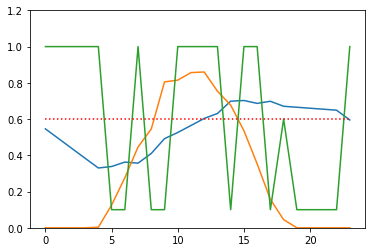

In [14]:
#PLOT GRAPHS
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([batt_dict[key]/BMAX for key in epoch])
ax.plot([henergy_dict[key]/HMAX for key in epoch])
ax.plot([node_consumption_dict[key]/NMAX for key in epoch])
ax.plot([BOPT/BMAX]*SLOTS, 'r:')
ax.set_ylim([0,1.2])
plt.show()
